# ✅ **EEG Eye State Dataset (UCI)**

##🔹**Import and Preparing Data**

In [10]:
from ucimlrepo import fetch_ucirepo
import pandas as pd
import numpy as np

# Fetching EEG dataset
eeg_eye_state = fetch_ucirepo(id=264)
X = eeg_eye_state.data.features
y = eeg_eye_state.data.targets

# Binary classification: Ensuring y is a 1D array
y = y.values.ravel()


##🔹 **PREPROCESSING**

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

# Standardization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [11]:
# Check for null and missing value
X.isnull().sum()

,0
AF3,0
F7,0
F3,0
FC5,0
T7,0
P7,0
O1,0
O2,0
P8,0
T8,0


##🔹 **FEATURE SELECTION**

In [13]:
from sklearn.feature_selection import SelectKBest, f_classif

selector = SelectKBest(score_func=f_classif, k=8)
X_train_sel = selector.fit_transform(X_train_scaled, y_train)
X_test_sel = selector.transform(X_test_scaled)

#✳️ **Models & Evaluation Function**

## 🔸**Evaluation Function**

In [14]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

def evaluate_model(name, y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    print(f"\n📊 {name} Evaluation:")
    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    return {"Model": name, "Accuracy": acc, "Precision": prec, "Recall": rec}


##🌲 **Random Forest**

In [15]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_sel, y_train)
rf_pred = rf.predict(X_test_sel)

rf_results = evaluate_model("Random Forest", y_test, rf_pred)


📊 Random Forest Evaluation:
Accuracy : 0.8628
Precision: 0.8872
Recall   : 0.7955


##🧠 **XGBoost**

In [16]:
from xgboost import XGBClassifier

xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb.fit(X_train_sel, y_train)
xgb_pred = xgb.predict(X_test_sel)

xgb_results = evaluate_model("XGBoost", y_test, xgb_pred)


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [04:20:07] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



📊 XGBoost Evaluation:
Accuracy : 0.8438
Precision: 0.8477
Recall   : 0.7948


##🔁 **LSTM**

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.utils import to_categorical

# Reshaping input: (samples, timesteps=1, features)
X_train_lstm = X_train_sel.reshape((X_train_sel.shape[0], 1, X_train_sel.shape[1]))
X_test_lstm = X_test_sel.reshape((X_test_sel.shape[0], 1, X_test_sel.shape[1]))

# Converting labels to categorical (for softmax)
y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)

# Building LSTM
lstm = Sequential([
    LSTM(32, input_shape=(1, X_train_sel.shape[1]), activation='tanh'),
    Dense(2, activation='softmax')
])

lstm.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Training the model
lstm.fit(X_train_lstm, y_train_cat, epochs=10, batch_size=32, verbose=0)

# Prediction
y_pred_lstm_prob = lstm.predict(X_test_lstm)
y_pred_lstm = np.argmax(y_pred_lstm_prob, axis=1)

lstm_results = evaluate_model("LSTM", y_test, y_pred_lstm)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

📊 LSTM Evaluation:
Accuracy : 0.6746
Precision: 0.6735
Recall   : 0.5338


##🔸 **Compare models result**

In [20]:
import pandas as pd

results_df = pd.DataFrame([rf_results, xgb_results, lstm_results])
print("\n📋 Model Comparison:\n")
print(results_df.to_markdown(index=False))


📋 Model Comparison:

| Model         |   Accuracy |   Precision |   Recall |
|:--------------|-----------:|------------:|---------:|
| Random Forest |   0.862817 |    0.887231 | 0.795539 |
| XGBoost       |   0.843792 |    0.84774  | 0.794796 |
| LSTM          |   0.674566 |    0.673546 | 0.533829 |


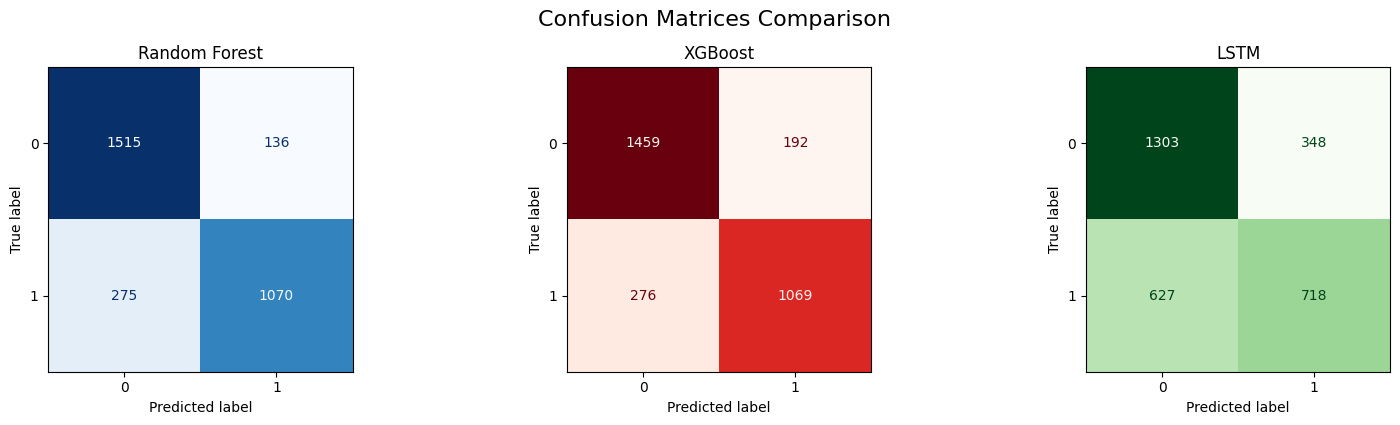

In [28]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


cm_rf = confusion_matrix(y_test, rf_pred)
cm_xgb = confusion_matrix(y_test, xgb_pred)
cm_lstm = confusion_matrix(y_test, y_pred_lstm)

fig, axes = plt.subplots(1, 3, figsize=(16, 4))

disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf)
disp_rf.plot(ax=axes[0], cmap='Blues', colorbar=False)
axes[0].set_title("Random Forest")

disp_xgb = ConfusionMatrixDisplay(confusion_matrix=cm_xgb)
disp_xgb.plot(ax=axes[1], cmap='Reds', colorbar=False)
axes[1].set_title("XGBoost")

disp_lstm = ConfusionMatrixDisplay(confusion_matrix=cm_lstm)
disp_lstm.plot(ax=axes[2], cmap='Greens', colorbar=False)
axes[2].set_title("LSTM")

plt.tight_layout()
plt.suptitle("Confusion Matrices Comparison", fontsize=16, y=1.05)
plt.show()


# **EEG Eye State Classification**

## 📌 **Problem Statement**

Develop a machine learning prototype that predicts **eye state (open or closed)** from EEG signal data. The goal is to classify fatigue or alertness levels from biosignals, which can support safety-critical systems such as driver drowsiness detection.

Dataset used: [EEG Eye State Dataset – UCI Repository](https://archive.ics.uci.edu/dataset/264/eeg+eye+state)

---

## 🧠 **Models Used**

Three supervised models were trained and compared:

| Model          | Library        | Input Format             |
|----------------|----------------|--------------------------|
| Random Forest  | scikit-learn   | 2D (tabular features)     |
| XGBoost        | xgboost        | 2D (tabular features)     |
| LSTM           | TensorFlow/Keras | 3D (sequence format, timesteps = 1) |

---

## ⚙️ **Data Preprocessing**

- **Null Handling**: No missing values
- **Standardization**: Features scaled using `StandardScaler`
- **Feature Selection**: Top 8 features selected via `SelectKBest`
- **Train-Test Split**: 80% training, 20% testing (stratified on target)

---

## 📊 **Evaluation Metrics**

All three models were evaluated using the following metrics:

- **Accuracy**
- **Precision**
- **Recall**
- **Confusion Matrix**

---

## 📈 **Results Summary**

| Model          | Accuracy | Precision | Recall |
|----------------|----------|-----------|--------|
| Random Forest  | ~0.86    | ~0.88     | ~0.79  |
| XGBoost        | ~0.84    | ~0.84     | ~0.79  |
| LSTM           | ~0.67    | ~0.67     | ~0.53  |


---

## 📁 **Files**

- `eeg_eye_state_model.ipynb`: Full model training and evaluation code
- `README.md`: This summary file
- `requirements.txt` (optional): List of required Python packages

---

## 🛰️ **Optional Digital Twin Integration**

This model can be embedded into a **Digital Twin of a vehicle driver** or **machine operator** equipped with real-time EEG sensors. The Digital Twin system would:

- Continuously monitor the user’s EEG signal
- Use the trained model to classify eye state (open/closed)
- Trigger alerts, slow down machinery, or activate autonomous features in case of drowsiness detection (eye closed over time)

---

## ✅ **Requirements**

- Python 3.7+
- Libraries: `pandas`, `numpy`, `scikit-learn`, `xgboost`, `tensorflow`, `ucimlrepo`, `matplotlib`, `seaborn`

Installed using:

```bash
pip install pandas numpy scikit-learn xgboost tensorflow ucimlrepo matplotlib seaborn
